In [12]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Amdahl's Law

## The starting example -- sorting

In [2]:
render_code("./gpusort/main.cu", show="main")

// ./gpusort/main.cu:516-682 (167 lines)
int main( int argc, char** argv)
{ 

  // Create timers for each sort
    struct timeval time_start, time_end, program_start, program_end;
    double input_time=0;
    gettimeofday(&program_start, NULL);	

    sdkCreateTimer(&uploadTimer);
    sdkCreateTimer(&downloadTimer);
    sdkCreateTimer(&bucketTimer);
    sdkCreateTimer(&mergeTimer);
    sdkCreateTimer(&totalTimer);
    sdkCreateTimer(&cpuTimer);
	int numElements = 0;
	int method=0;
    // Number of elements in the test bed
    	gettimeofday(&time_start, NULL);
#ifdef READING_FROM_BINARY
        numElements = atoi(argv[2]);
	if (argc == 4)
		method = atoi(argv[3]);
#else
       	if(strcmp(argv[1],"r") ==0) {
	         numElements = SIZE; 
	    }
	else {
		FILE *fp;
	    fp = fopen(argv[1],"r");
	    if(fp == NULL) {
	        cout << "Error reading file" << endl;
	        exit(EXIT_FAILURE);
	    }
	    int count = 0;
	    float c;

	    while(fscanf(fp,"%f",&c) != EOF) {
	        count++;
        }
	    fclose(fp);
	    numElements = count;
    }
#endif

	cout << "Sorting list of " << numElements << " floats\n";
	// Generate random data
	// Memory space the list of random floats will take up
	int mem_size = numElements * sizeof(float); 
	// Allocate enough for the input list
	float *cpu_idata = (float *)malloc(mem_size);
	// Allocate enough for the output list on the cpu side
	float *cpu_odata = (float *)malloc(mem_size);
	// Allocate enough memory for the output list on the gpu side
	float *gpu_odata = (float *)malloc(mem_size);

	float datamin = FLT_MAX; 
	float datamax = -FLT_MAX; 
	if(strcmp(argv[1],"r")==0) {

	for (int i = 0; i < numElements; i++) {
	// Generate random floats between 0 and 1 for the input data
		cpu_idata[i] = ((float) rand() / RAND_MAX); 
	//Compare data at index to data minimum, if less than current minimum, set that element as new minimum
		datamin = min(cpu_idata[i], datamin);
	//Same as above but for maximum
		datamax = max(cpu_idata[i], datamax);
	}
    }	else {
	FILE *fp;
#ifdef READING_FROM_BINARY
	fp = fopen(argv[1],"rb");
	fread(cpu_idata,sizeof(float),numElements,fp);
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
	
    /*	for(int i = 0; i < numElements; i++) {
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}*/

	datamin = 0.0;
	datamax = 16777215.0;
#else
	fp = fopen(argv[1],"r");
	for(int i = 0; i < numElements; i++) {
	fscanf(fp,"%f",&cpu_idata[i]);
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
    	gettimeofday(&time_start, NULL);	
#endif
	}
#ifndef CPU
	cout << "Sorting on GPU..." << flush; 
	// GPU Sort
	if(method == 0)
	for (int i = 0; i < TEST; i++) 
        MergeSort(cpu_idata, numElements, THREADS_PER_BLOCK, numElements/THREADS_PER_BLOCK);
//		gpu_quicksort(cpu_idata, gpu_odata, numElements);		
	else {
	// Using bitonic sort
	for (int i = 0; i < TEST; i++) 
		bitonic_sort(cpu_idata, gpu_odata, numElements);		
	}
#endif

#if defined(VERIFY) || (defined CPU)
	cout << "Sorting on CPU..." << flush; 
	// Start_CPU_Sort
	sdkStartTimer(&cpuTimer); 
	memcpy(cpu_odata, cpu_idata, mem_size);
    qsort(cpu_odata, numElements, sizeof(float), compare);
	sdkStopTimer(&cpuTimer); 
    // End_CPU_Sort 
	cout << "done.\n";
	#ifdef VERIFY
    cout << "Checking result..." << flush; 
	// Result checking
	int count = 0; 
	for(int i = 0; i < numElements; i++)
		if(fabs(cpu_odata[i] - gpu_odata[i])> 0.0002)
		{
			printf("Sort missmatch on element %d: \n", i); 
			printf("CPU = %f : GPU = %f\n", cpu_odata[i], gpu_odata[i]); 
			count++; 
			break; 
		}

## Where is the most time critical part of my program?

In [11]:
! cd gpusort; make clean; make
! echo "File on H.D.D.; Sorting on CPU"
! cd ./gpusort; echo "ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort.csv; source ./run_CPU 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on CPU
Sorting list of 134217728 floats
FileInput 1.846912 seconds
Sorting on CPU...done.
Total CPU execution time: 14.664255 seconds


In [12]:
display_df_mono(render_csv("./gpusort/sort.csv", columns=["ET","FileInput","CPU_Kernel"]))

,ET,FileInput,CPU_Kernel
0,16.511199,1.846912,14.664255


In [ ]:
! lscpu

### Use gprof to figure out the timing breakdown

In [5]:
! cd gpusort; make clean; make EXTRA_FLAGS=-pg 
! cd ./gpusort; source ./run_CPU

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
Sorting list of 134217728 floats
FileInput 2.081336 seconds
Sorting on CPU...done.
Total CPU execution time: 26.007383 seconds
28.088750, 2.081336, 26.007383, 0.000000, 0.000000, 0.000000


In [6]:
! cd gpusort; gprof ./hybridsort_cpu ./gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
 76.73      1.34     1.34                             compare(void const*, void const*)
 23.28      1.74     0.41                             StopWatchLinux::getAverageTime()
  0.00      1.74     0.00        1     0.00     0.00  _GLOBAL__sub_I_uploadTimer
  0.00      1.74     0.00        1     0.00     0.00  __sti____cudaRegisterAll()

 %         the percentage of the total running time of the
time       program used by this function.

cumulative a running sum of the number of seconds accounted
 seconds   for by this function and those listed above it.

 self      the number of seconds accounted for by this
seconds    function alone.  This is the major sort for this
           listing.

calls      the number of times this function was invoked, if
           this function is profiled, else blank.

 self      the 

## Amdahl's Law -- optimizating is a moving target

In [7]:
render_code("./gpusort/main.cu", lang="c++", show="bitonic_sort")

// ./gpusort/main.cu:63-92 (30 lines)
void bitonic_sort(float *values, float *out_values, int num_of_elements)
{
  float *dev_values;
  size_t size = num_of_elements * sizeof(float);
  int BLOCKS = num_of_elements/THREADS_PER_BLOCK; 

  cudaMalloc((void**) &dev_values, size);
  sdkStartTimer(&uploadTimer);
  cudaMemcpy(dev_values, values, size, cudaMemcpyHostToDevice);
  sdkStopTimer(&uploadTimer); 
  dim3 blocks(BLOCKS,1);    /* Number of blocks   */
  dim3 threads(THREADS_PER_BLOCK,1);  /* Number of threads  */

  sdkStartTimer(&totalTimer); 
  int j, k;
  /* Major step */
  for (k = 2; k <= num_of_elements; k <<= 1) {
    /* Minor step */
    for (j=k>>1; j>0; j=j>>1) {
      bitonic_sort_step<<<blocks, threads>>>(dev_values, j, k);
    }
  }
		cudaThreadSynchronize(); 
  sdkStopTimer(&totalTimer); 
  sdkStartTimer(&downloadTimer);
  cudaMemcpy((void *)out_values, (void *)dev_values,  num_of_elements*sizeof(float), cudaMemcpyDeviceToHost);
//		checkCudaErrors(cudaMemcpy((void *)out_values, (void *)dev_values, num_of_elements*sizeof(float), cudaMemcpyDeviceToHost));
  sdkStopTimer(&downloadTimer); 
  cudaFree(dev_values);
}

In [8]:
! nvidia-smi -a


==============NVSMI LOG==============

Timestamp                                 : Thu Apr 11 09:49:57 2024
Driver Version                            : 550.54.14
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 4070
    Product Brand                         : GeForce
    Product Architecture                  : Ada Lovelace
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Enabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial N

In [13]:
! cd gpusort; make clean; make
# ! ssh htseng@azelf "source ./courses/CS203/demo/amdahlslaw/gpusort/run_CPU"
! echo "File on H.D.D.; Sorting on GPU"
! cd gpusort; source ./run 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 1.832176 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.757153 seconds
    - Upload		: 0.042431 seconds
    - Download		: 0.141571 seconds


In [14]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,16.511199,1.846912,14.664255,0.000000,0.000000,0.000000
1,2.854206,1.832176,0.000000,0.757153,0.042431,0.141571


In [14]:
! echo "File on S.S.D.; Sorting on GPU"
! cd gpusort; source ./run_SSD 2>> sort.csv

File on S.S.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 0.241281 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 2.670223 seconds
    - Upload		: 0.051498 seconds
    - Download		: 0.144367 seconds


In [ ]:
display_df_mono(render_csv("./gpusort/sort.csv"))

## Amdahl's Law on parallel programming

In [18]:
! cd vmul; make clean; make
! echo "THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST" > ./vmul/vmul.csv
! echo "CPU based vul"
! time ./vmul/vmul 33554432 1 0 30 2>> ./vmul/vmul.csv
! echo "GPU based vul"
### i stands for "How many iterations each thread performs 
### -- the larger the number, the fewer the parallelism
! for i in 1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192; do time ./vmul/vmul 33554432 $i 1 30 2>> ./vmul/vmul.csv ; done

rm -f vmul *.o
gcc -O3 vmul.c -c
gcc -O3 vmul_cpu.c -c
/usr/local/cuda/bin/nvcc -O3 -w vmul_cuda.cu -c
gcc -O3 *.o -lcuda -lcudart -L/usr/local/cuda/lib64 -o vmul
CPU based vul
Using CPU
kernel: 0.279851 seconds

real	0m0.677s
user	0m0.557s
sys	0m0.060s
GPU based vul
memcpy (to device): 0.116116 seconds
Using GPU
kernel: 0.055460 seconds
memcpy (to host): 0.022713 seconds

real	0m0.557s
user	0m0.335s
sys	0m0.151s
memcpy (to device): 0.076680 seconds
Using GPU
kernel: 0.021067 seconds
memcpy (to host): 0.019791 seconds

real	0m0.533s
user	0m0.330s
sys	0m0.138s
memcpy (to device): 0.076455 seconds
Using GPU
kernel: 0.039027 seconds
memcpy (to host): 0.019822 seconds

real	0m0.544s
user	0m0.336s
sys	0m0.154s
memcpy (to device): 0.096119 seconds
Using GPU
kernel: 0.045661 seconds
memcpy (to host): 0.019882 seconds

real	0m0.562s
user	0m0.352s
sys	0m0.143s
memcpy (to device): 0.085042 seconds
Using GPU
kernel: 0.071002 seconds
memcpy (to host): 0.019632 seconds

real	0m0.577s
user	0m0.369s


,THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST,TOTAL
0,0.000000,0.279851,0.000000,0.000000,0.000000,0.279851
14,4.000000,0.000000,0.082099,0.296612,0.020015,0.398726
13,8.000000,0.000000,0.097834,0.150239,0.019747,0.267820
12,16.000000,0.000000,0.076418,0.077641,0.022524,0.176583
11,32.000000,0.000000,0.096913,0.088377,0.019792,0.205082
10,64.000000,0.000000,0.099602,0.088043,0.019902,0.207547
9,128.000000,0.000000,0.079772,0.076084,0.019857,0.175713
8,256.000000,0.000000,0.077001,0.075861,0.019717,0.172579
7,512.000000,0.000000,0.076792,0.071726,0.019626,0.168144
6,1024.000000,0.000000,0.076254,0.072304,0.019680,0.168238


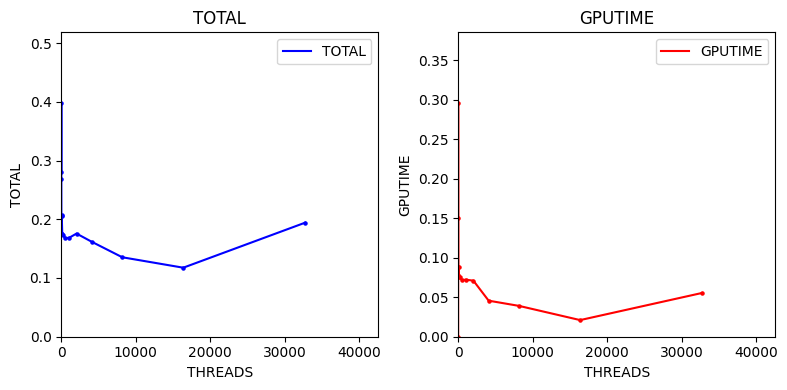

In [19]:
df = render_csv("./vmul/vmul.csv")
df["TOTAL"] = df["CPUTIME"] + df["HOST2GPU"] + df["GPUTIME"] + df["GPU2HOST"]
df = df.sort_values(by=["THREADS"], ascending=True)
display_df_mono(df)
plotPE(df=df, lines=True, what=[ ('THREADS', "TOTAL"), ('THREADS', "GPUTIME")], columns=2)

# Choose the "right" metrics

## Throughput and Latency

### GPU performance

Let's compare the performance of running matrix multiplications on GPU is get a feeling about the difference between "throughput" and latency

In [13]:
! cd ./metrics; ./cudamm 16 1

Data Type Size: 4
Time elapsed on matrix multiplication of 16x16 . 16x16 on GPU: 0.077792 ms.


Throughput: 0.11 GFLOPS



In [14]:
! cd ./metrics; ./cudamm 32 1

Data Type Size: 4
Time elapsed on matrix multiplication of 32x32 . 32x32 on GPU: 0.079648 ms.


Throughput: 0.82 GFLOPS



In [15]:
! cd ./metrics; ./cudamm 64 1

Data Type Size: 4
Time elapsed on matrix multiplication of 64x64 . 64x64 on GPU: 0.085696 ms.


Throughput: 6.12 GFLOPS



What do you find regarding the "latencies" of these three cases?

What do you find regarding the "throughput" of these three cases?

In [ ]:
### SSD v.s. HDD

You may use to hdparm (need root permission to execute). The /dev/sda on this machine is an SATA SSD that has around 450-500MB/sec bandwidth. The /dev/md0 is a RAID contains two H.D.Ds in RAID-0 configuration that also achieves 450-500MB/sec bandwidth. Let's examine the bandwidth using the following command.

In [ ]:
from IPython.display import IFrame
IFrame("https://hub.escalab.org:8000/user/htseng/terminals/1", width="100%", height="400")

Now, let's revisit the optimized gpusort on this machine with different array size...

In [6]:
! echo "Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 512 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 512 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 32768 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 32768 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 262144 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 262144 2>> ../sort_small.csv
display_df_mono((render_csv("sort_small.csv")))

File on H.D.D
Sorting list of 512 floats
FileInput 0.000982 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.002195 seconds
    - Upload		: 0.000919 seconds
    - Download		: 0.000008 seconds
Sorting list of 512 floats
FileInput 0.001032 seconds
Sorting on CPU...done.
Total CPU execution time: 0.000088 seconds
File on S.S.D
Sorting list of 512 floats
FileInput 0.001026 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.001858 seconds
    - Upload		: 0.000740 seconds
    - Download		: 0.000012 seconds
Sorting list of 512 floats
FileInput 0.000941 seconds
Sorting on CPU...done.
Total CPU execution time: 0.000107 seconds
File on H.D.D
Sorting list of 32768 floats
FileInput 0.001812 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.002601 seconds
    - Upload		: 0.000839 seconds
    - Download		: 0.000049 seconds
Sorting list of 32768 floats
FileInput 0.001335 seconds
Sorting on CPU...done.
Total CPU execution ti

,Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,HDD+GPU,512,0.104483,0.000982,0.000000,0.002195,0.000919,0.000008
1,HDD+CPU,512,0.001160,0.001032,0.000088,0.000000,0.000000,0.000000
2,SSD+GPU,512,0.102187,0.001026,0.000000,0.001858,0.000740,0.000012
3,SSD+CPU,512,0.001083,0.000941,0.000107,0.000000,0.000000,0.000000
4,HDD+GPU,32768,0.096655,0.001812,0.000000,0.002601,0.000839,0.000049
5,HDD+CPU,32768,0.006248,0.001335,0.004889,0.000000,0.000000,0.000000
6,SSD+GPU,32768,0.074123,0.000640,0.000000,0.002559,0.000798,0.000055
7,SSD+CPU,32768,0.010425,0.000834,0.009545,0.000000,0.000000,0.000000
8,HDD+GPU,262144,0.079579,0.005118,0.000000,0.002638,0.000850,0.000344
9,HDD+CPU,262144,0.035357,0.005529,0.029781,0.000000,0.000000,0.000000


What can we observe here?

## FLOPs

In [58]:
! cd metrics; make
! cd ./metrics; ./cpumm 2048 512

make: Nothing to be done for 'all'.
Data type size: 4

Time: 4465.740 ms

Throughput: 3.85 GFLOPS



In [59]:
! cd ./metrics; ./cudamm 128 1

Data Type Size: 4
Time elapsed on matrix multiplication of 128x128 . 128x128 on GPU: 0.122976 ms.


Throughput: 34.11 GFLOPS



In [60]:
! cd ./metrics; ./cudamm 256 1

Data Type Size: 4
Time elapsed on matrix multiplication of 256x256 . 256x256 on GPU: 0.240960 ms.


Throughput: 139.25 GFLOPS



In [61]:
! cd ./metrics; ./cudamm 2048 1

Data Type Size: 4
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 15.069920 ms.


Throughput: 1140.01 GFLOPS



In [16]:
! cd ./metrics; ./cudamm 4096 1

Data Type Size: 4
Time elapsed on matrix multiplication of 4096x4096 . 4096x4096 on GPU: 93.849762 ms.


Throughput: 1464.46 GFLOPS



In [17]:
! cd metrics; ./cudamm 8192 1

Data Type Size: 4
Time elapsed on matrix multiplication of 8192x8192 . 8192x8192 on GPU: 677.673767 ms.


Throughput: 1622.48 GFLOPS



In [18]:
! cd metrics; ./cudamm_double 2048 1

Data Type Size: 8
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 53.367905 ms.


Throughput: 321.91 GFLOPS



In [11]:
! cd metrics;  ./cudamm_double 2048 0

Data Type Size: 8
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 53.452255 ms.


Throughput: 321.41 GFLOPS



In [8]:
! cd metrics; ./cpumm_double 2048 512

Data type size: 8

Time: 4924.322 ms

Throughput: 3.49 GFLOPS



In [9]:
! cd metrics;  ./cudamm 2048 0

Data Type Size: 4
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 17.448671 ms.


Throughput: 984.59 GFLOPS

